# Set up

The following package will download the TSV files from IMDB website and store the data into a SQLite database (requires 10GB of disk space)


In [ ]:
!pip install imdb-sqlite

2022-01-05 16:41:09,799 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-01-05 16:41:57,095 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz


In [1]:
%%time
!imdb-sqlite

2022-01-05 16:43:35,556 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-01-05 16:44:29,399 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2022-01-05 16:44:54,502 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2022-01-05 16:45:37,525 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2022-01-05 16:46:40,863 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2022-01-05 16:46:46,442 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2022-01-05 16:46:47,522 Populating database: imdb.db
2022-01-05 16:46:47,523 Applying schema
2022-01-05 16:46:47,526 Importing file: downloads/name.basics.tsv.gz
2022-01-05 16:46:47,526 Reading number of rows ...
2022-01-05 16:46:52,852 Inserting rows into table: people
100%|█████████████████████████| 11310385/11310385 [02:04<00:00, 90634

In [3]:
# Need this package for hadling country ISO codes
!pip install pycountry

In [6]:
# Imports

import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib import cm # Color maps
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts

In [8]:
# Some tweaks

warnings.filterwarnings('ignore') # Don't show warnings
sns.set_theme(style = 'whitegrid')

# Database structure analysis

In [9]:
# Connect to databse
conn = sqlite3.connect('imdb.db')

In [15]:
# Retrieve tables' names
tables = pd.read_sql_query('SELECT name AS "Table_name" FROM sqlite_master WHERE type="table" LIMIT 5', conn)
tables.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [25]:
# Retrieve each table's schema

tables_names = tables['Table_name'].values.tolist()

for table_name in tables_names:
    schema = pd.read_sql_query(f'PRAGMA TABLE_INFO({table_name})', conn)
    print(f'Schema for table {table_name}:')
    display(schema)
    print(f'{50 * "_"}\n\n')

Schema for table people:


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


__________________________________________________


Schema for table titles:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


__________________________________________________


Schema for table akas:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


__________________________________________________


Schema for table crew:


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


__________________________________________________


Schema for table episodes:


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


__________________________________________________




# 1. The most common content categories in IMDB

In [62]:
# Retrieve the data
query = 'SELECT type, COUNT(*) AS abs_frequency FROM titles GROUP BY type ORDER BY abs_frequency DESC'
dataframe = pd.read_sql_query(query, conn)
display(dataframe)

,type,abs_frequency
0,tvEpisode,6404250
1,short,849453
2,movie,598170
3,video,256280
4,tvSeries,218814
5,tvMovie,134354
6,tvMiniSeries,41405
7,tvSpecial,35501
8,videoGame,30088
9,tvShort,10427


In [63]:
# Remove tvEpisode type
dataframe = dataframe.drop(labels = 0, axis = 0)

In [64]:
# Add the relative_frequency
sum_abs_freq = dataframe['abs_frequency'].sum()
dataframe['rel_frequency'] = (dataframe['abs_frequency'] / sum_abs_freq) * 100
display(dataframe)

,type,abs_frequency,rel_frequency
1,short,849453,39.064398
2,movie,598170,27.508469
3,video,256280,11.785730
4,tvSeries,218814,10.062755
5,tvMovie,134354,6.178633
6,tvMiniSeries,41405,1.904121
7,tvSpecial,35501,1.632610
8,videoGame,30088,1.383678
9,tvShort,10427,0.479514
10,tvPilot,2,0.000092


Now let's create a graph with 5 categories:

4 categories with the the biggest amount of titles.

1 category with the others


In [65]:
# Others category
others = {}
others['type'] = 'others'
others['abs_frequency'] = dataframe.iloc[4:]['abs_frequency'].sum()
others['rel_frequency'] = dataframe.iloc[4:]['rel_frequency'].sum()
others

{'type': 'others',
 'abs_frequency': 251777,
 'rel_frequency': 11.578647722182724}

In [66]:
# The common title categories dataframe
dataframe = dataframe.head(4)
dataframe = dataframe.append(others, ignore_index = True) # Append others category
dataframe = dataframe.sort_values(by = 'rel_frequency', ascending = False)
dataframe

,type,abs_frequency,rel_frequency
0,short,849453,39.064398
1,movie,598170,27.508469
2,video,256280,11.785730
4,others,251777,11.578648
3,tvSeries,218814,10.062755


In [80]:
# Labels
labels = []

for i in dataframe.index:
    cont_type = dataframe.loc[i]["type"]
    cont_type = re.sub(r"(\w)([A-Z])", r"\1 \2", cont_type) # Add space before capital letters
    cont_type = cont_type[0].upper() + cont_type[1:] # Uppercase the first letter without changing the rest
    
    rel_freq = round(dataframe.loc[i]["rel_frequency"], 2)
    
    labels.append(f'{cont_type} {rel_freq}%')
    
labels

['Short 39.06%',
 'Movie 27.51%',
 'Video 11.79%',
 'Others 11.58%',
 'Tv Series 10.06%']

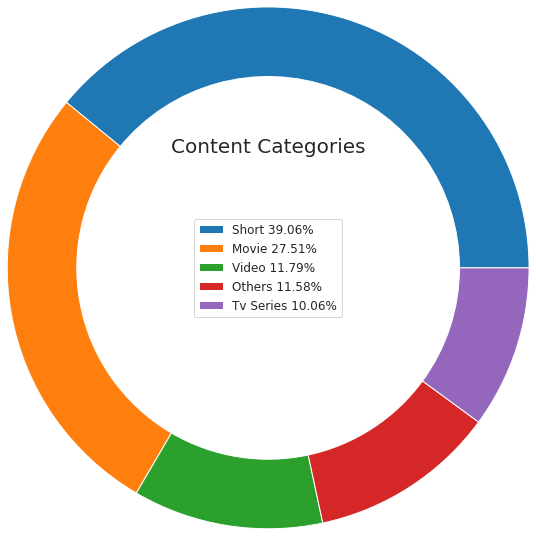

In [94]:
# Plot

# Set color map
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.tab10(range(100))

plt.pie(dataframe['rel_frequency'], colors = cs, labeldistance = 1, radius = 3, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', fontsize = 12)
plt.title(label = 'Content Categories', loc = 'center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

